In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
#The data relevant to our research question is in the following two files. Note these contain background information about patients (age, sex, etc), as well as information obtained at the paitent's arrival at the ED. 
# Although there is other data available, it is obtained later in the patient's ED stay.
edstays = pd.read_csv('ed_data/edstays.csv.gz', compression='gzip')
triage = pd.read_csv('ed_data/triage.csv.gz', compression='gzip')

In [17]:
# Merge these two dataframes along the stay_id column.
df=pd.merge(edstays, triage, how='outer', on='stay_id')

#Note that the stay_id column and the subject_id column are common to both of the original dataframes. 
# The dataframes were merged along the say_id, but this results in duplication of the subject ID column. 

df.head()




,subject_id_x,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,subject_id_y,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,11714491,21562392.0,30000012,2126-02-14 20:22:00,2126-02-15 01:59:00,F,WHITE,AMBULANCE,ADMITTED,11714491,98.8,96.0,18.0,93.0,160.0,54.0,0,2.0,CHANGE IN MENTAL STATUS
1,14230614,NaN,30000017,2185-06-18 11:51:00,2185-06-18 15:53:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ELOPED,14230614,NaN,73.0,18.0,97.0,156.0,112.0,0,3.0,"ETOH, Unable to ambulate"
2,13821532,26255538.0,30000038,2152-12-07 16:37:00,2152-12-07 19:55:00,F,WHITE,AMBULANCE,ADMITTED,13821532,97.1,54.0,18.0,95.0,143.0,73.0,0,3.0,Cough
3,13340997,23100190.0,30000039,2165-10-06 11:47:00,2165-10-06 20:18:00,M,WHITE,WALK IN,ADMITTED,13340997,98.6,85.0,16.0,98.0,189.0,96.0,0,3.0,s/p Fall
4,19848164,NaN,30000055,2155-07-18 17:03:00,2155-07-18 21:12:00,F,OTHER,WALK IN,HOME,19848164,99.4,85.0,16.0,100.0,NaN,NaN,0,3.0,L Ear pain


In [18]:
# First check that these columns are in fact duplicates.

differences = (df['subject_id_x'] != df['subject_id_y']).sum()
print(differences)

#Now eliminate the duplicate and simplify variable name:
df.drop('subject_id_y', axis=1, inplace=True)
df.rename(columns={'subject_id_x': 'subject_id'}, inplace=False)

df.head()



0


,subject_id_x,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,11714491,21562392.0,30000012,2126-02-14 20:22:00,2126-02-15 01:59:00,F,WHITE,AMBULANCE,ADMITTED,98.8,96.0,18.0,93.0,160.0,54.0,0,2.0,CHANGE IN MENTAL STATUS
1,14230614,NaN,30000017,2185-06-18 11:51:00,2185-06-18 15:53:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ELOPED,NaN,73.0,18.0,97.0,156.0,112.0,0,3.0,"ETOH, Unable to ambulate"
2,13821532,26255538.0,30000038,2152-12-07 16:37:00,2152-12-07 19:55:00,F,WHITE,AMBULANCE,ADMITTED,97.1,54.0,18.0,95.0,143.0,73.0,0,3.0,Cough
3,13340997,23100190.0,30000039,2165-10-06 11:47:00,2165-10-06 20:18:00,M,WHITE,WALK IN,ADMITTED,98.6,85.0,16.0,98.0,189.0,96.0,0,3.0,s/p Fall
4,19848164,NaN,30000055,2155-07-18 17:03:00,2155-07-18 21:12:00,F,OTHER,WALK IN,HOME,99.4,85.0,16.0,100.0,NaN,NaN,0,3.0,L Ear pain


In [19]:
#Let's check on missing values for our variable.sum
#First we check how many missing values there are for each variable. 
df.isna().sum()

subject_id_x              0
hadm_id              222071
stay_id                   0
intime                    0
outtime                   0
gender                    0
race                      0
arrival_transport         0
disposition               0
temperature           23415
heartrate             17090
resprate              20353
o2sat                 20596
sbp                   18291
dbp                   19091
pain                  12933
acuity                 6987
chiefcomplaint           23
dtype: int64

In [20]:
#I don't expect we are using hadmin_id, so that's not a big deal. The other variables with missing values are important. 
#Investigate this more by checking how these missing values are distributed. The following compute the number of missing values 
# in each row and then looks at the distribution of this count. It appears that for all but 4 cases, we have at least partial information
# for the triage variables. This makes it reasonble to do some kind of imputation here.
df.isna().sum(axis=1).value_counts()

1     218900
0     178989
2       8255
6       6074
8       5347
7       2962
3       1741
9       1687
4        600
5        528
10         4
Name: count, dtype: int64

In [ ]:
#Here I compute the target variable, stay length, in terms of hours.
df['stay_length']=pd.to_datetime(df['outtime'])-pd.to_datetime(df['intime'])
df['stay_length_hours']= df['stay_length'].dt.total_seconds() / 3600

In [25]:
#Also, let's take a look at the target variable, stay_length_hours.

df['stay_length_hours'].describe()

count    425087.000000
mean          7.158327
std           6.628000
min         -22.733333
25%           3.533333
50%           5.466667
75%           8.316667
max         493.069444
Name: stay_length_hours, dtype: float64

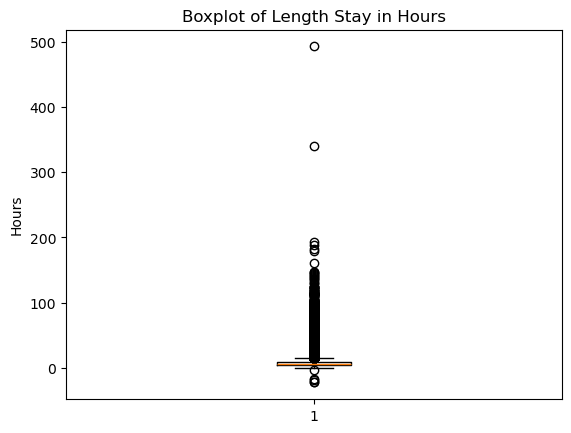

In [ ]:
#A boxplot of the distribution of the stay length in hours.

plt.boxplot(df['stay_length_hours'])
plt.title('Boxplot of Length Stay in Hours')
plt.ylabel('Hours')
plt.show()

In [26]:
#There are some values for stay_length_hours, which are negative. This is nonsensical. Let's check how many of these there are.


(df['stay_length_hours'] < 0).sum()


np.int64(6)

In [ ]:
#Here I have added extra variables, day of the week and time of day, for the intime. 
df['day_of_week_intime'] = pd.to_datetime(df['intime']).dt.dayofweek
df['time_of_day_intime'] = pd.to_datetime(df['intime']).dt.time